In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import matplotlib.colors as colors
import h5py
import nbimporter
from _create_pdf import create_spins;
from _helper_functions import tsallis, cauchy, find_nearest_index;
from _steady_state import a_steady;
#%qtconsole

Importing Jupyter notebook from _create_pdf.ipynb
Importing Jupyter notebook from _helper_functions.ipynb
Importing Jupyter notebook from _steady_state.ipynb


In [2]:
gcoll = 2*np.pi #HWHM
q = 1.39
quali = 914
fr = 3.2981e3;
kappa = np.pi*fr/quali #HWHM
delta = 0*2*np.pi #detuning cavity to spin central frequency ws-wc
deltac = 0*2*np.pi #detuning drive to cavity wc-wp
gperp = 2*np.pi*0.09 #HWHM
gpar = 2*np.pi*.001#0.001 #HWHM
gammaq = 2*np.pi*2 #FWHM
nbins = 701#701#5000#20
#g0 = gcoll/sqrt(nspins)
print(kappa)

11.33619992429376


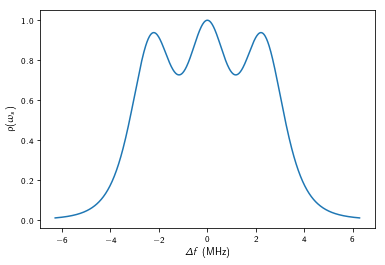

In [3]:
bool_holes = False
bool_inhomo = True
bool_hyperfine = True
spins, gs, pdf = create_spins(gcoll, q, delta, gammaq, nbins, holes=bool_holes, inhomo=bool_inhomo, hyperfine=bool_hyperfine)

plt.figure()
plt.plot(spins, pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('$\\rho(\omega_s)$');
%qtconsole

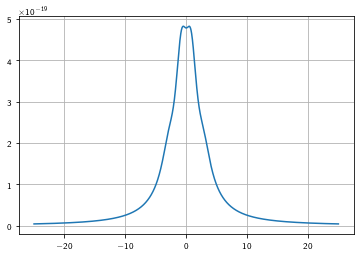

In [4]:
initsteady = (0.1,0.1)
fstart = 25
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 2000)
etasteady = 0.00000001

losasteady = np.zeros(np.shape(deltaarr))


newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2


fig = plt.figure()
plt.plot(deltaarr/2/np.pi, losasteady)
plt.grid(True)
#deltaarr[find(losasteady == max(losasteady))]/2/pi

In [5]:
filepath = '/mnt/samba2/experiments/Quantum InterConnect/Cryogenics/Dilution Fridge/LogFiles/SyncFolderAcqiris/Measurements/2016/20181214_MeasurementRun111/referenceVnaTrace.mat'
exp = {}
data = scipy.io.loadmat(filepath)['referenceVnaTrace']
#exp = dict(f['/data/referenceTrace'])
imagpart = data[0][0][10]
realpart = data[0][0][9]
freqstart = float(data[0][0][0])
freqstop = float(data[0][0][1])
numpoints = int(data[0][0][2])

freqs = (np.linspace(freqstart, freqstop, numpoints)-(freqstart+freqstop)/2)*1e-6

power = np.squeeze(imagpart**2+realpart**2)

### Fit Coupling

In [6]:
def fitfunc(freqs, g, ampl, offset, freqoff):
    newinit = (0.01,0.01)
    losasteady = np.zeros(np.shape(freqs))
    gs = np.sqrt(pdf)*g
    for i, delt in enumerate(freqs):
        ar, ai = a_steady(etasteady, delt*2*np.pi, gs, spins + freqoff, gpar, gperp, kappa, newinit)
        newinit = (ar, ai)
        losasteady[i] = ai**2+ar**2
    losasteady *= ampl/max(abs(losasteady))
    losasteady += offset
    return losasteady

def fitfunc2(freqs, g, ampl, offset, freqoff, gammaq, q):
    newinit = (0.01, 0.01)
    losasteady = np.zeros(np.shape(freqs))
    spins, gs, pdf = create_spins(g, q, freqoff*2*np.pi, gammaq, nbins, holes=bool_holes, inhomo=bool_inhomo, hyperfine=bool_hyperfine)
    
    for i, delt in enumerate(freqs):
        ar, ai = a_steady(etasteady, delt*2*np.pi, gs, spins, gpar, gperp, kappa, newinit)
        newinit = (ar, ai)
        losasteady[i] = ai**2+ar**2
    losasteady *= ampl/max(abs(losasteady))
    losasteady += offset
    return losasteady

p0 = [1.90476693e+01, 9.88492617e-03, 1.90652967e-05, 2.08134119e-01]
popt, pcov = scipy.optimize.curve_fit(fitfunc, freqs, power.ravel(), p0=p0)
pn = np.array([ popt[0], popt[1], popt[2],  popt[3],
        1.43769887e+01,  2.1])
print("Finished first iteration")
popt2, pcov2 = scipy.optimize.curve_fit(fitfunc2, freqs, power.ravel(), p0=pn)
print("Finished second interation")

Finished first iteration
Finished second interation


Coupling: 2.98 MHz
Linewidth: 2.06 MHz
q-value: 2.140330
Frequency offset: -0.06 MHz


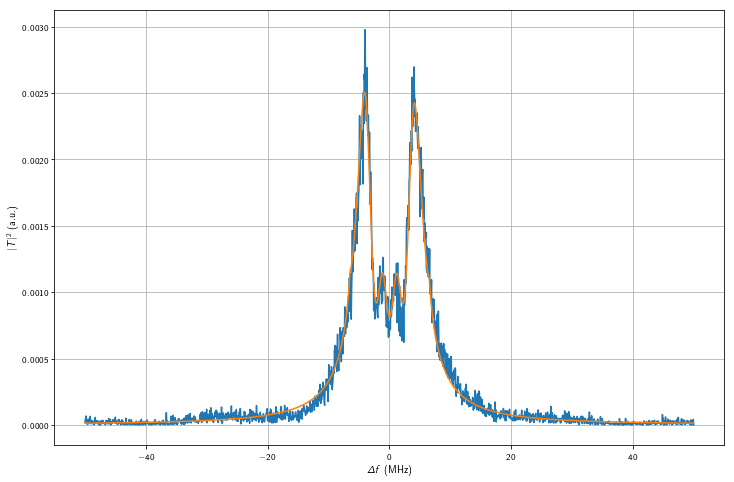

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(freqs, power)
plt.plot(freqs, fitfunc2(freqs, *popt2))
plt.grid(True)
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('$|T|^2$ (a.u.)')
print('Coupling: %.2f MHz'%(popt2[0]/2/np.pi))
print('Linewidth: %.2f MHz'%(popt2[-2]/2/np.pi))
print('q-value: %f'%popt2[-1])
print('Frequency offset: %.2f MHz'%popt2[-3])

In [ ]:
print('Coupling, q-value, linewidth')
print(popt2[0], popt2[-1], popt2[-2])